In [1]:
import os
os.chdir("..")

In [2]:
import sys
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
from datetime import datetime
sys.path.insert(0, os.getcwd())

import tensorflow as tf
import matplotlib.pyplot as plt
import pennylane as qml

from tqdm import tqdm
import utilities.translator.tfq_translator as tfq_translator
import utilities.evaluator.evaluator as tfq_evaluator
import utilities.variational.tfq.variational as tfq_minimizer
import utilities.simplification.simplifier as penny_simplifier
import utilities.simplification.misc as simplification_misc#.kill_and_simplify
import utilities.simplification.tfq.gate_killer as tfq_killer
import utilities.database.database as database
import utilities.database.templates as templates
import utilities.mutator.idinserter as idinserter
import running.misc.misc as miscrun
import argparse
import ast
from importlib import reload


In [3]:
js = np.array([0] + list(np.logspace(-7,-2,7)))


In [13]:
def load_ev(ns):
    args = {"problem":"TFIM", "params":"[1.,1.]","nrun":0, "shots":0, "epochs":500, "n_qubits":4, "vans_its":200,"itraj":-1, "noisy":True, "noise_strength":ns, "acceptange_percentage": 0.01, "L_HEA":2}
    args = miscrun.FakeArgs(args)
    L_HEA = args.L_HEA
    problem = args.problem
    params = ast.literal_eval(args.params)
    shots = miscrun.convert_shorts(args.shots)
    epochs = args.epochs
    n_qubits = args.n_qubits
    learning_rate=1e-4
    acceptange_percentage = args.acceptange_percentage
    noise_strength = args.noise_strength
    int_2_bool = lambda x: True if x==1 else False
    noisy = int_2_bool(args.noisy)
    tf.random.set_seed(abs(args.itraj))
    np.random.seed(abs(args.itraj))

    translator = tfq_translator.TFQTranslator(n_qubits = n_qubits, initialize="x", noisy=args.noisy, noise_strength = noise_strength)#, device_name="forest.numpy_wavefunction")
    translator_killer = tfq_translator.TFQTranslator(n_qubits = translator.n_qubits, initialize="x", noisy=translator.noisy, noise_strength = args.noise_strength)
    minimizer = tfq_minimizer.Minimizer(translator, mode="VQE", hamiltonian = problem, params = params, lr=learning_rate, shots=shots, patience=30, max_time_training=600, verbose=0)
    simplifier = penny_simplifier.PennyLane_Simplifier(translator)
    killer = tfq_killer.GateKiller(translator, translator_killer, hamiltonian=problem, params=params, lr=learning_rate, shots=shots, accept_wall = 2/args.acceptange_percentage)
    inserter = idinserter.IdInserter(translator, noise_in_rotations=1e-1, mutation_rate = 1.5)
    args_evaluator = {"n_qubits":translator.n_qubits, "problem":problem,"params":params,"nrun":args.itraj}
    evaluator = tfq_evaluator.PennyLaneEvaluator(minimizer = minimizer, killer=killer, inserter = inserter, args=args_evaluator, lower_bound=translator.ground, stopping_criteria=1e-3, vans_its=args.vans_its, acceptange_percentage = acceptange_percentage)

    evaluator.load_dicts_and_displaying(evaluator.identifier)
    return evaluator

In [21]:
costs = {}
for ns in js:

    evaluator = load_ev(ns)
    data = []
    for k in evaluator.evolution.values():
        data.append(k)
    costs[ns] = [k[1] for k in data]

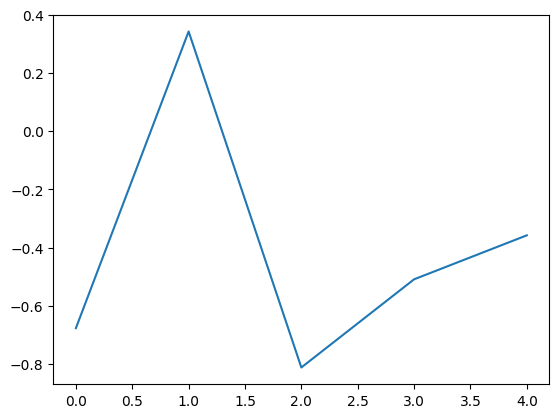

In [31]:
plt.plot(costs[js[5]])

In [33]:
coco = np.stack(costs.values())

In [37]:
coco.shape

(8, 5)

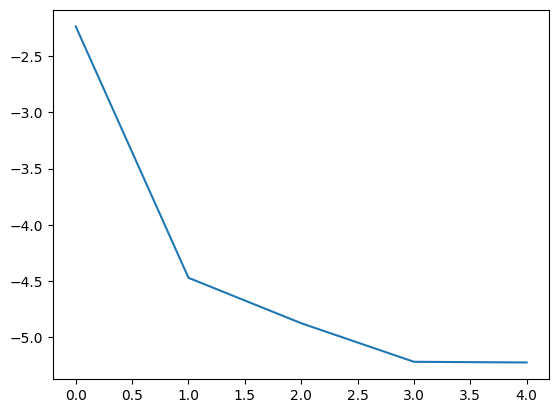

In [35]:
plt.plot(coco[0])

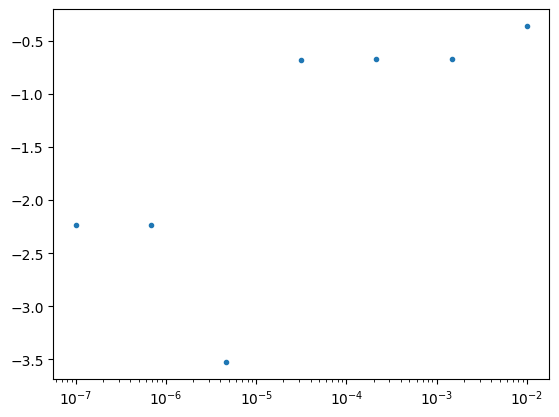

In [46]:
ax=plt.subplot()
ax.plot(js,coco[:,0],'.')
ax.set_xscale("log")